# Preliminaries

Relevant links: 
- [Gaussian Processes for Machine Learning - CH 2](https://gaussianprocess.org/gpml/chapters/RW2.pdf)

In [1]:
using LinearAlgebra
using Distributions 
using Random
using Plots

First let's set up some data that we can use for training our Guassian Process Regressor

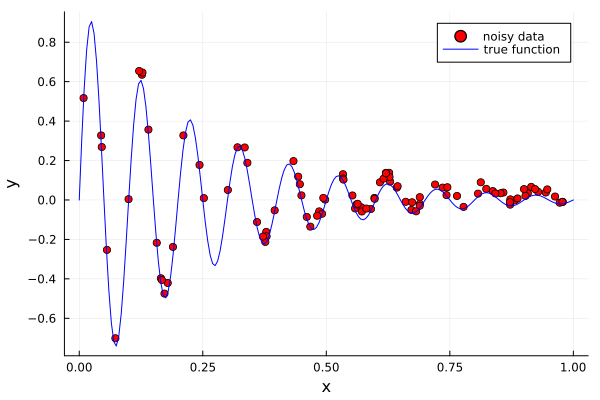

In [43]:
# the noisy function we want to fit
function make_training_data(n, ν)
    xs = 0:0.005:1 # for plotting
    X = rand(n) 
    
    y(x) = (exp(-x/(0.5)^2) * sin(2π*ν*x)) + (0.25)^2*rand()
    ytrue(x) = exp(-x/(0.5)^2) * sin(2π*ν*x)

    return X', y.(X), xs, ytrue.(xs)
end



X, y, xs, ytrue = make_training_data(100, 10)

plot(X', y, seriestype=:scatter, color=:red, label="noisy data")
plot!(xs,ftrue.(xs), color=:blue, label="true function")
xlabel!("x")
ylabel!("y")

# Weight-space View

There are two equivalent ways to arrive that the formulation for guassian process regression (GPR): 
1. The **weight-space** view 
2. The **function-space** view

We begin with the weight space view as it is a natural extension of standard linear regression when we make considerations for guassian distributed noise in observations. 

## Terminology 

We consider a training set, $\mathcal{D}$ with $n$ observations 
\begin{equation}
    \mathcal{D} = \left\{ (\mathbf{x}_i, y_i) \; \vert \; i=1,...,n \right\}
\end{equation}
- $\mathbf{x}_i$ is the ith, $D$-dimensional input (feature) vector 
- $y_i$ is the ith target

Linear regression is best accomplished via linear algebra. We therefore collect our dataset into a $D \times n$ dimensional **Design Matrix**
\begin{equation}
X := \begin{pmatrix} 
\vdots & \vdots & & \vdots \\ 
\mathbf{x}_1 & \mathbf{x}_2 & ... & \mathbf{x}_n \\
\vdots & \vdots & & \vdots 
\end{pmatrix}
\end{equation}

and our targets into a target vector

\begin{equation}
\mathbf{y} := (y_1, ..., y_n)
\end{equation}
so that the full training set becomes 
\begin{equation}
\mathcal{D} := (X, \mathbf{y})
\end{equation}

## The Standard Linear Model

Standard linear regression is a model of the form 
\begin{equation} 
f(x) = \mathbf{x}^T\mathbf{w} 
\end{equation} 
where the vector $\mathbf{w}$ is the $D$-dimensional vector of weights. By minimizing the mean-squared-error loss function, one can show that the optimal weights of the system are given by
\begin{equation}
\mathbf{w} = (XX^T)^{-1}X\mathbf{y}
\end{equation}

Note: this can also be easily obtained geometrically by finding the vector with the shortest distance to the hyperplane defined by the column space of $X$. This corresponds to solve the **Normal Equations** 
\begin{equation}
XX^T\mathbf{w} = X\mathbf{y} 
\end{equation}


The following demonstrates this procedure on some simple data

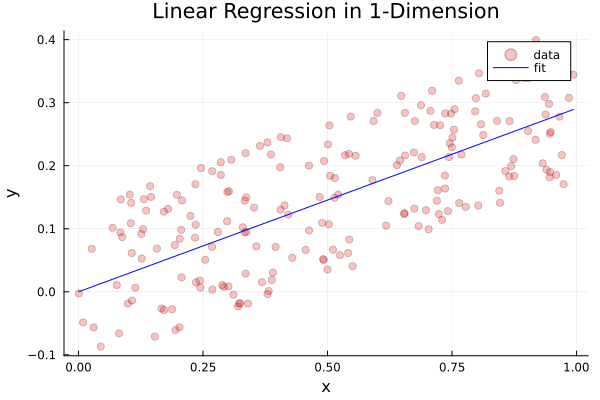

In [44]:
X = rand(200)
y = 0.3 .* X .+ 0.25 .* (rand(200) .- 0.5)
X = X'

w = (X*X')\(X*y)
ypred = X'*w

plot(X', y, 
    seriestype=:scatter,
    color=:red, alpha=0.25, 
    label="data")

plot!(X', ypred, color=:blue, label="fit")
xlabel!("x")
ylabel!("y")
title!("Linear Regression in 1-Dimension")

**Note**: We can also fit a y intercept (bias) by augmenting the input vector $X$  with an aditional element whose value is alwyas 1, i.e. setting 
\begin{equation} 
X[D+1, :] = (1, ..., 1)
\end{equation}

## Making it Bayesian

Standard linear regression assumes that our data $\mathcal{D}$ are perfect but we can clearly see that the above data are noisy. To account for this, we can make our model *Bayesian* by augmenting our model such that 
\begin{align} 
    f(\mathbf{x}) &= \mathbf{x}^T\mathbf{w} \\ 
    y &= f(\mathbf{x}) + \epsilon \\ 
    \epsilon &\sim \mathcal{N}(0, \sigma_n^2)
\end{align}

Here we are saying that the observed values differ from the *truth* by independent, identically distributed (i.i.d.) guassian noise with zero mean and variance $\sigma_n^2$

The noise model together with it's corresponding distribution allow us to consider the *likelihood*, that is, the probability density of our observations given the model parameters: 
\begin{align} 
p(\mathbf{y}\vert X,\mathbf{w}) &:= \prod\limits_i^n p(y_i \vert \mathbf{x}_i, \mathbf{w}) \\
&= \prod\limits_i^n \frac{1}{\sqrt{2\pi\sigma_n^2}}\exp\left( -\dfrac{(y_i-\mathbf{x}_i^T\mathbf{w})^2}{2\sigma_n^2}\right)\\
&= \dfrac{1}{(2\pi\sigma_n^2)^{n/2}}\exp\left( -\frac{1}{2\sigma_n^2}\lvert \mathbf{y} - X^T\mathbf{w}\rvert^2 \right) \\
&= \mathcal{N}\left(X^T\mathbf{w}, \sigma_n^2I\right)
\end{align} 


Because we are being Bayesians (and not frequentists), we are allowed to encode our assumptions about the distriubtion of possible parameter vectors $\mathbf{w}$ via a **Bayesian Prior**, that is 
\begin{equation}
    p(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \Sigma_p)
\end{equation}

The reson for this particular choice will become clear in the following derivation. For now, let's just use it and see what happens. 

To perform inference with our updated model, we apply Baye's Rule, that is: 
\begin{equation}
p(\mathbf{w}\vert\mathbf{y}, X) = \dfrac{p(\mathbf{y}\vert X, \mathbf{w})p(\mathbf{w})}{p(\mathbf{y}\vert X)}
\end{equation}
where 
- $p(\mathbf{w}\vert\mathbf{y}, X)$ is the **posterior distribution** 
- $p(\mathbf{y}\vert X, \mathbf{w})$ is the **likelihood**
- $p(\mathbf{w})$ is the **prior distribution**
- $p(\mathbf{y}\vert X)$ is the **marginal likelihood**, i.e. the normalization constant

It is now that the utility of choosing gaussian distributions  for our likelihood and prior becomes clear... 
\begin{align}
p(\mathbf{w}\vert\mathbf{y},X) &\propto \exp\left(-\frac{1}{2\sigma_n^2}(\mathbf{y}-X^T\mathbf{w})^T(\mathbf{y}-X^T\mathbf{w}) \right)\exp\left(-\frac{1}{2}\mathbf{w}^T\Sigma_p^{-1}\mathbf{w}\right)
\end{align}
Taking the log and expanding leads to
\begin{align}
\log(p(\mathbf{w}\vert \mathbf{y}, X))&= \frac{1}{2}\left[ \frac{1}{\sigma_n^2}\mathbf{y}^T\mathbf{y} - \frac{1}{\sigma_n^2}\mathbf{y}^TX^T\mathbf{w} - \frac{1}{\sigma_n^2}\mathbf{w}^TX\mathbf{y} + \frac{1}{\sigma_n^2}\mathbf{w}^TXX^T\mathbf{w} + \mathbf{w}^T\Sigma_p^{-1}\mathbf{w}\right] \\
&= \frac{1}{2}\left[ \mathbf{w}^T\left(\frac{1}{\sigma_n^2}XX^T+\Sigma_p^{-1}\right)\mathbf{w} -\left(\frac{1}{\sigma_n^2}\mathbf{y}^TX^T\right)\mathbf{w} - \mathbf{w}^T\left(\frac{1}{\sigma_n^2}X\mathbf{y}\right)  + \mathbf{y}^T\frac{1}{\sigma_n^2}\mathbf{y}\right]\\ 
&= \mathbf{w}^TA\mathbf{w} - B^T\mathbf{w} - \mathbf{w}^TB + C
\end{align}
where we have defined
\begin{align}
A &:= \frac{1}{\sigma_n^2}XX^T + \Sigma_p^{-1} \\ 
B &:= \frac{1}{\sigma_n^2}X\mathbf{y} \\ 
C &:= \mathbf{y}^T\frac{1}{\sigma_n^2}\mathbf{y}
\end{align}

Now we can complete the square so that
\begin{equation}
\mathbf{w}^TA\mathbf{w} - B^T\mathbf{w} - \mathbf{w}^TB + C = \left(\mathbf{w} - \bar{\mathbf{w}} \right)^TA\left(\mathbf{w} - \bar{\mathbf{w}} \right) + K
\end{equation}
leading to 
\begin{align}
\bar{\mathbf{w}} &= A^{-1}B = \frac{1}{\sigma_n^2}\left(\frac{1}{\sigma_n^2}XX^T + \Sigma_p^{-1}\right)^{-1}X\mathbf{y} \\ 
K &= C- \bar{\mathbf{w}}^TA\bar{\mathbf{w}}
\end{align}
Since $K$ does not depend on $\mathbf{w}$ directly, it may be absorbed into the normalization of $p(\mathbf{w}\vert \mathbf{y}, X)$. Thus we are left with

--- 

\begin{align}
p(\mathbf{w}\vert\mathbf{y},X) &= \mathcal{N}\left( \bar{\mathbf{w}}=\frac{1}{\sigma_n^2}A^{-1}X\mathbf{y}, \Sigma=A^{-1}\right) \\ 
A &= \frac{1}{\sigma_n^2}XX^T+\Sigma_p^{-1}
\end{align}

---

This result gives us the gaussian distriubtion over the space of possible parameter vectors $\mathbf{w}$. To use this distribution to make predictions, consider a newly supplied testpoint $\mathbf{x}_*$. We want to find 
\begin{equation}
p(y_* \vert \mathbf{x}_*, \mathbf{y}, X) 
\end{equation}

We do this by marginalizing over our weight distribution, i.e. 
\begin{equation}
p(y_* \vert \mathbf{x}_*, \mathbf{y}, X) = \int_{\mathbf{w}} p(y_*\vert \mathbf{x}_*,\mathbf{w})p(\mathbf{w}\vert \mathbf{y}, X)d\mathbf{w}
\end{equation}
If we make the further assumption that testing points are i.i.d. guassian distriubted, we see that this integral is the product of two gaussians and therefore is also a guassian. To find the mean and covariance of the predictive distribution, we check 
\begin{align} 
    \bar{y}_* &= \mathbb{E}[y_*] = \mathbb{E}[\mathbf{x}_*^T\mathbf{w}] = \mathbf{x}_*^T\mathbb{E}[\mathbf{w}] = \mathbf{x}_*^T\bar{\mathbf{w}} \\ 
    \text{Cov}(y_*) &= \mathbb{E}[(y_*-\bar{y}_*)(y_*-\bar{y}_*)^T] \\ 
    &= \mathbb{E}[(\mathbf{x}_*^T\mathbf{w}-\mathbf{x}_*^T\bar{\mathbf{w}})(\mathbf{x}_*^T\mathbf{w}-\mathbf{x}_*^T\bar{\mathbf{w}})^T] \\ 
    &= \mathbb{E}[\mathbf{x}_*^T(\mathbf{w}-\bar{\mathbf{w}})(\mathbf{w}-\bar{\mathbf{w}})^T\mathbf{x}_*] \\ 
    &= \mathbf{x}_*^T\mathbb{E}[(\mathbf{w}-\bar{\mathbf{w}})(\mathbf{w}-\bar{\mathbf{w}})^T]\mathbf{x}_* \\ 
    &= \mathbf{x}_*^T\text{Cov}(\mathbf{w})\mathbf{x}_* \\
    &= \mathbf{x}_*^TA^{-1}\mathbf{x}_*
\end{align} 
so that 
\begin{equation}
\boxed{p(y_* \vert \mathbf{x}_*, \mathbf{y}, X) = \mathcal{N}\left(\mathbf{x}_*^T\mathbf{w},\;  \mathbf{x}_*^TA^{-1}\mathbf{x}_*\right)}
\end{equation}

# Doing More with Less: Kernelization

Let's take a break from our Bayesian regression and return to standard linear regression for a moment. The key drawback of linear models is, of course, that they're *linear*! Considering that many (most?) *interesting* relationships are not linear, how can we extend our simple linear model to enable us to perform complicated non-linear fits? 

In the parlance of machine learning, the simple solution is to do **Feature Engineering**. If our inital feature vector is 
\begin{equation}
\mathbf{x} = (x_1, ..., x_n) 
\end{equation}
we can use our *expertise* to concot new combinations of these features to produce the agumented vector 
\begin{equation}
\tilde{\mathbf{x}} = (x_1, ..., x_n, x_1^2, \;sin(x_2), \;x_5x_7/x_4,\;...) 
\end{equation}

As an example, a linear classifier is unable to distinguish points inside a circle from those outside just from the $(x,y)$ coordinates alone. Augmenting the feature vector to include the squared radius $x^2+y^2$ as a new feature removes this obstacle. 

## Generalizing our Regression Model

Constructing new features is often more art than science. To standardize the process, let's abstract mapping from the original feature vector $\mathbf{x}$ to the augmented vector $\tilde{\mathbf{x}}$. This is accomplished via the projection map $\phi:\mathbb{R}^D \to \mathbb{R}^N$ where
\begin{equation}
    \mathbf{x} \mapsto \tilde{\mathbf{x}} = \phi(\mathbf{x})
\end{equation}

The result is that our linear model updates to become 
\begin{equation}
f(\mathbf{x}) := \phi(\mathbf{x})^T\mathbf{w}
\end{equation}
where the weight vector has gone from $D$ dimensional to $N$ dimensional. 

Similarly, the normal equations for $\mathbf{w}$ update to become 
\begin{equation}
\mathbf{w} = (\Phi\Phi^T)^{-1}\Phi\mathbf{y}
\end{equation}
where $\Phi = \phi(X)$ is the $N\times n$ matrix resulting from applying $\phi$ columnwise to $X$. 

The following example shows how to use such a mapping to produce a quadratic polynomial fit. 

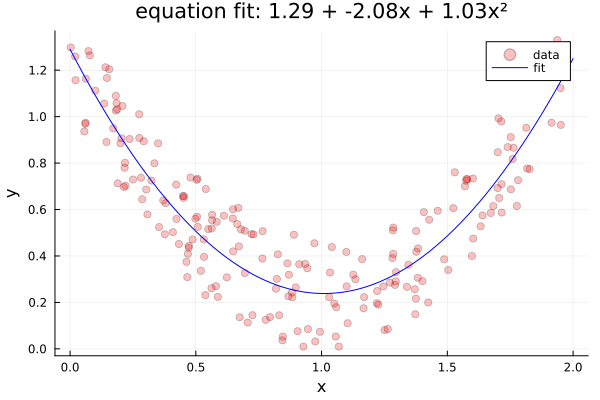

In [115]:
X = 2*rand(200)
y =  1.0 .- 2.0 .* X .+ X.^2 .+ (0.5 .* rand(200))
X = X'

# compute projection
Φ(x) = [1.0, x...,[x[i]*x[j] for i∈1:size(x,1) for j∈1:size(x,1)]...]
X̃ = hcat([Φ(col) for col ∈ eachcol(X)]...)

# fit the parameters
w = (X̃*X̃')\(X̃*y)

# compute projection on test points
Xpred = collect(0:0.025:2)
Xpred = Xpred'
X̃pred = hcat([Φ(col) for col ∈ eachcol(Xpred)]...)

# compute prediction on test points
ypred = X̃pred'*w

# visualize
plot(X', y, 
    seriestype=:scatter,
    color=:red, alpha=0.25, 
    label="data")

plot!(Xpred', ypred, color=:blue, label="fit")
xlabel!("x")
ylabel!("y")
title!("equation fit: $(round(w[1],digits=2)) + $(round(w[2], digits=2))x + $(round(w[3], digits=2))x²")



We see from the above that our linear regression model found a great fit for a 2nd order polynomial when supplied with polynomial features. 

Note: there is a *massive* problem with this method. Our order 2 polynomial map $\phi$ takes us from a $D$ dimenional feature vector to $(D+1)!$ many. This means that as we add more features to our feature map, the dimension of the resulting vector will quickly become prohibitively large. 


## Bayesian Regression with Feature Mappings 

Let's ignore the problem of dimensionality for the moment and update our Bayesian regression scheme to make use of our feature projection map $\phi$. First we define 
\begin{align} 
    \Phi &:= \phi(X) \\ 
    \phi_* &:= \phi(\mathbf{x}_*)
\end{align}

Our predictive distribution therefore becomes
\begin{align}
    p(y_* \vert \mathbf{x}_*, X, \mathbf{y}) &= \mathcal{N}\left(\frac{1}{\sigma_n^2}\phi_*^TA^{-1}\Phi\mathbf{y}, \;\phi_*^TA^{-1}\phi_*\right) \\ 
    A &= \frac{1}{\sigma_n^2}\Phi\Phi^T + \Sigma_p^{-1}
\end{align}
Great! Now we can do our Bayesian inference with non-linear features given by $\phi$.

Returning to the problem of the dimensionality of our augmented feature vectors $\phi(\mathbf{x})$, we see that the computational bottleneck is the matrix inversion of $A$ which requires we invert an $N\times N$ matrix. 

Note that our prediction (i.e. the mean) involves multiplication on the right by the $n$ dimensional vector $\mathbf{y}$. With that in mind, perhaps we can reformulate the above into an equivalent form using at most an $n\times n$ dimensional matrix...

Let $K:= \Phi^T\Sigma_p\Phi$. Observe the following:
\begin{align} 
    \frac{1}{\sigma_n^2}\Phi(K+\sigma_n^2I) &= \frac{1}{\sigma_n^2}\Phi\left(\Phi^T\Sigma_p\Phi + \sigma_n^2I \right) \\ 
    &= \frac{1}{\sigma_n^2}\Phi\Phi^T\Sigma_p\Phi + \Phi I \\ 
    &= \left(\frac{1}{\sigma_n^2}\Phi\Phi^T \right)\Sigma_p\Phi + \left(\Phi I \Phi^{-1}\Sigma_p^{-1} \right)\Sigma_p\Phi \\ 
    &= \left(\frac{1}{\sigma_n^2}\Phi\Phi^T + \Sigma_p^{-1}\right)\Sigma_p\Phi \\ 
    &= A\Sigma_p\Phi
\end{align}

From there we see that 
\begin{align} 
    A^{-1}\frac{1}{\sigma_n^2}\Phi\left(K+\sigma_n^2I\right) &= \Sigma_p\Phi \\ 
    \Rightarrow \frac{1}{\sigma_n^2}A^{-1}\Phi &= \Sigma_p\Phi\left(K + \sigma_n^2I\right)^{-1} \\ 
    \Rightarrow \frac{1}{\sigma_n^2}\phi_*^TA^{-1}\Phi &= \phi_*^T\Sigma_p\Phi\left(K + \sigma_n^2I\right)^{-1}
\end{align} 

For the covariance, we utilize the matrix inversion lemma which states 
\begin{equation}
 (Z + UWV^T)^{-1} = Z^{-1} - Z^{-1}U(W^{-1} + V^TZ^{-1}U)^{-1}V^TZ^{-1}
\end{equation}

With the identification 
\begin{align}
    Z^{-1} &\to \Sigma_p \\ 
    W^{-1} &\to \sigma_n^2I \\ 
    V &\to \Phi \\ 
    U &\to \Phi 
\end{align}
we find 
\begin{align}
\Sigma_p - \Sigma_p\Phi\left(\Sigma_p + \Phi^T\Sigma_p\Phi \right)^{-1}\Phi^T\Sigma_p  &= \left(\Sigma_p^{-1} + \Phi\frac{1}{\sigma_n^2}I\Phi^T\right)^{-1}\\ 
&= \left(\frac{1}{\sigma_n^2}\Phi\Phi^T + \Sigma_p^{-1}\right)^{-1}  \\ 
&= A^{-1} 
\end{align}

Thus, we have the equivalent form for our predictive distribution: 
\begin{equation}
\boxed{p(y_*\vert \mathbf{x}_*, X, \mathbf{y}) =\\ \mathcal{N}\left( \phi_*^T\Sigma_p\Phi(K+\sigma_n^2I)^{-1}\mathbf{y}, \; \phi_*^T\Sigma_p\phi_* - \phi_*^T\Sigma_p\Phi(K+\sigma_n^2I)^{-1}\Phi^T\Sigma_p\phi_*\right)}
\end{equation}

but the pesky $N\times N$ term has now been replaces by the $n\times n$ matrix $\Phi^T\Sigma_p\Phi$. 

## Kernelization

We now make the the *key* observation that the only matrices that appear in the above expression are 
\begin{align}
    &\Phi^T\Sigma_p\Phi &\phi_*^T\Sigma_p\phi_* \\ 
    &\phi_*^T\Sigma_p\Phi &\Phi^T\Sigma_p\phi_*
\end{align}
whose matrix elements we can write abstractly as 
\begin{equation}
\phi(\mathbf{x})^T\Sigma_p\phi(\mathbf{x}')
\end{equation}

This key observation allows us to make the abstraction: To fit our model, we must determine appropriate values for the symmetric, positive semi-definite covariance matrix $\Sigma_p$ (and \sigma_n too, technically). Instead, we observe that this matrix product is a quadratic form which we can think of as representing an inner product on our transformed vectors: 
\begin{equation}
K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j) = \langle \phi(\mathbf{x}_i), \phi(\mathbf{x}_j)\rangle
\end{equation}
We call the function $k(\mathbf{x},\mathbf{x}')$ the **kernel function** or the *covariance function*.  

All we need to perform the above calculations are the matrix elements of K on our data $\mathcal{D}$ and any test points $\mathbf{x}_*$ we wish to apply our model to. In effect, this means we are free to use feature vectors **of any dimension, including $\infty$**.

There are many choices for the kernel function. One of the most popular is the RBF (radial basis function) kernel, also known as the *squared exponential kernel*: 

\begin{equation}
k_{\text{rbf}}(\mathbf{x}, \mathbf{x}') := \sigma_f^2\exp(-\frac{1}{2\ell^2}\lvert \mathbf{x}-\mathbf{x}'\rvert^2)
\end{equation}

where $\sigma_f^2$ is the *signal variance* and $\ell$ denotes the similarity length scale. 

For notational convenience, let's define 
\begin{align}
    K &:= k(X,X) \\ 
    K_{**} &:= k(X_*, X_*) \\ 
    K_{*} &:= k(X, X_*)
\end{align}

then, our predictive distribution takes the final, *clean* form
\begin{equation}
\boxed{p(\mathbf{y}_* \vert X_*, X, \mathbf{y}) = \mathcal{N}\left( K_*^T(K+\sigma_n^2I)^{-1}\mathbf{y},\; K_{**}-K_{*}^T(K+\sigma_n^2I)^{-1}K_*\right)}
\end{equation}